# Plot time series data with plotly using multiindex data frame

## imports

In [75]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import json
import cufflinks as cf
import plotly.express as px
#%matplotlib inline
from plotly.offline import download_plotlyjs
#from plotly.offline import init_notebook_mode
from plotly.offline import plot, iplot
#init_notebook_mode(connected=True)
#cf.go_offline()
import chart_studio.plotly as py
import plotly.graph_objects as go


# Function definition

In [2]:
def aggregate_data(data_in, grouping_variables, aggregation_variable, confidence_level=0.95, use_t_dist_for_ci=True):
    # todo code here!
    stats = data_in.groupby(grouping_variables)[aggregation_variable].agg(['mean','median', 'count', 'std', 'min', 'max'])

    intervals_hi = []
    intervals_lo = []

    for i in stats.index:
        mean, median, count, std, min, max = stats.loc[i]
        SE = std/(math.sqrt(count))

        #deceide which distribution to use
        if use_t_dist_for_ci:
            degrees = count - 1
            intervals = st.t.interval(confidence_level, degrees, loc=mean, scale = SE)
        else:
            intervals = st.norm.interval(confidence_level, loc=mean, scale = SE)


        #apply the upper and lower intervals according to their values
        if intervals[0] > intervals [1]:
            intervals_hi.append(intervals[0])
            intervals_lo.append(intervals[1])
        else:
            intervals_lo.append(intervals[0])
            intervals_hi.append(intervals[1])

    stats['ci95_lo'] = intervals_lo
    stats['ci95_hi'] = intervals_hi
    return stats

#TODO compare different types to calculate confidence interval

## Read data


In [261]:
#read data
how = "inner"
column_name = "run"
#merge data
data_in = pd.read_csv("data_ma/compareTwoParam/AverageDesireSatisfactionLevel.2021.Mai.29.21_56_10.csv")
param_in = pd.read_csv("data_ma/compareTwoParam/AverageDesireSatisfactionLevel.2021.Mai.29.21_56_10.batch_param_map.csv")
#data_in = pd.read_json("data_uni/infections.2021.aug.17.08_53_42.json")
#param_in = pd.read_json("data_uni/infections.2021.aug.17.08_53_42.batch_param_map.json")
data_in

,run,tick,DesireBelonging,DesireEsteem,DesirePhysio,DesireSafety,DesireSelfActualization
0,1,1.0,0.485641,0.490231,0.480647,0.495891,0.489781
1,1,4.0,0.485261,0.491049,0.455044,0.486306,0.488067
2,1,7.0,0.507690,0.519677,0.437024,0.474030,0.515645
3,1,10.0,0.519846,0.535806,0.415691,0.458816,0.531892
4,1,13.0,0.526231,0.545860,0.396946,0.445523,0.544049
...,...,...,...,...,...,...,...
26995,300,256.0,0.451272,0.483169,0.241910,0.387933,0.524744
26996,300,259.0,0.449687,0.481221,0.240781,0.386295,0.522446
26997,300,262.0,0.449275,0.481212,0.240060,0.385607,0.522565
26998,300,265.0,0.451021,0.482652,0.240290,0.385624,0.523227


In [185]:
#find unique experiments
all_params = param_in.drop(columns=['run', 'randomSeed'])
#all_params
params_unique = all_params.drop_duplicates()
#params_unique#.columns,
#variables are:
number_of_distinct_experiments = len(params_unique)

In [ ]:
nunique = params_unique.nunique()
cols_to_drop = nunique[nunique == 1].index
params_unique.drop(cols_to_drop, axis=1)

#USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE
#USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_LEARNING
#USE_SOCIAL_PRESSURE
#USE_SOCIAL_LEARNING



In [336]:
merged_data = data_in.merge(param_in, left_on=column_name, right_on=column_name, how=how)

merged_data

,run,tick,DesireBelonging,DesireEsteem,DesirePhysio,DesireSafety,DesireSelfActualization,USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_LEARNING,DESIRE_SAFETY_DECAY,DRF_MAX_TOTAL_INPUT,...,LIMIT_INTENTION_REFLECTING_UTIL_BASED_ON_DSL,SOCIAL_SUPPORT_EFFECT,DAYS_TO_SIMULATE,randomSeed,SOCIAL_LEARNING_EMOTIONAL_AUTONOMY_FACTOR,DESIRE_DECAY_BASE_RATE,DRF_CALCULATION_STATIC_INFLUENCE,DESIRE_ESTEEM_IMPORTANCE_FACTOR,DESIRE_PHYSIO_IMPORTANCE_FACTOR,ALLWAYS_INIT_NETWORK
0,1,1.0,0.485641,0.490231,0.480647,0.495891,0.489781,False,0.2,1.0,...,False,0.5,90,-1186300987,1.0,0.25,0.3,1.0,1.0,False
1,1,4.0,0.485261,0.491049,0.455044,0.486306,0.488067,False,0.2,1.0,...,False,0.5,90,-1186300987,1.0,0.25,0.3,1.0,1.0,False
2,1,7.0,0.507690,0.519677,0.437024,0.474030,0.515645,False,0.2,1.0,...,False,0.5,90,-1186300987,1.0,0.25,0.3,1.0,1.0,False
3,1,10.0,0.519846,0.535806,0.415691,0.458816,0.531892,False,0.2,1.0,...,False,0.5,90,-1186300987,1.0,0.25,0.3,1.0,1.0,False
4,1,13.0,0.526231,0.545860,0.396946,0.445523,0.544049,False,0.2,1.0,...,False,0.5,90,-1186300987,1.0,0.25,0.3,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,300,256.0,0.451272,0.483169,0.241910,0.387933,0.524744,False,0.2,1.0,...,False,0.5,90,-1179697960,1.0,0.25,0.3,1.0,1.0,False
26996,300,259.0,0.449687,0.481221,0.240781,0.386295,0.522446,False,0.2,1.0,...,False,0.5,90,-1179697960,1.0,0.25,0.3,1.0,1.0,False
26997,300,262.0,0.449275,0.481212,0.240060,0.385607,0.522565,False,0.2,1.0,...,False,0.5,90,-1179697960,1.0,0.25,0.3,1.0,1.0,False
26998,300,265.0,0.451021,0.482652,0.240290,0.385624,0.523227,False,0.2,1.0,...,False,0.5,90,-1179697960,1.0,0.25,0.3,1.0,1.0,False


In [340]:
merged_data["first_factor"] = merged_data["SOCIAL_PRESSURE_EFFECT"]
merged_data["second_factor"] = merged_data["USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE"]
#update true / false to yes / no
filter_true = (merged_data["second_factor"] == True)
filter_false = (merged_data["second_factor"] == False)
merged_data["second_factor"]

0         True
1         True
2         True
3         True
4         True
         ...  
26995    False
26996    False
26997    False
26998    False
26999    False
Name: second_factor, Length: 27000, dtype: bool

In [343]:
merged_data.loc[filter_true, "second_factor"] = "yes"
merged_data.loc[filter_false, "second_factor"] = "no"
subset = merged_data.loc[:, ["run", "tick", "DesireBelonging", "first_factor", "second_factor"]]
subset.to_json("pandas_data_frame.json")

In [266]:
#set aggregation type
aggregationVariable = 'DesireBelonging'
#group_by_string = '["tick"]'
#group_by_string = '["tick","USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE","USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_LEARNING","USE_SOCIAL_PRESSURE","USE_SOCIAL_LEARNING"]'
#group_by_string = '["tick","USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE","SOCIAL_PRESSURE_EFFECT"]'

group_by_string = '["tick","first_factor","second_factor"]'

groupingVariables = json.loads(group_by_string)

#aggregate
my_stats = aggregate_data(merged_data, groupingVariables, aggregationVariable)
#my_stats.to_json("data_ma/sampleData.json")
my_stats




mean    median  count       std  \
tick  first_factor second_factor                                        
1.0   0.00         no             0.489803  0.489291     30  0.004103   
                   yes            0.489626  0.489175     30  0.004610   
      0.25         no             0.490416  0.490188     30  0.003058   
                   yes            0.490440  0.490955     30  0.003531   
      0.50         no             0.490133  0.490833     30  0.003642   
...                                    ...       ...    ...       ...   
268.0 0.50         yes            0.469987  0.469942     30  0.000963   
      0.75         no             0.459094  0.459207     30  0.001609   
                   yes            0.467484  0.467925     30  0.001422   
      1.00         no             0.449855  0.449570     30  0.001749   
                   yes            0.464206  0.464293     30  0.001207   

                                       min       max   ci95_lo   ci95_hi  
tick  first_factor second_factor                                          
1.0   0.00         no             0.480890  0.499673  0.488271  0.491335  
                   yes            0.479253  0.499235  0.487905  0.491348  
      0.25         no             0.483497  0.495958  0.489274  0.491557  
                   yes            0.483509  0.497344  0.489122  0.491759  
      0.50         no             0.483114  0.496181  0.488773  0.491493  
...                                    ...       ...       ...       ...  
268.0 0.50         yes            0.468108  0.471690  0.469627  0.470346  
      0.75         no             0.456083  0.461940  0.458494  0.459695  
                   yes            0.464921  0.470434  0.466953  0.468015  
      1.00         no             0.445721  0.452786  0.449202  0.450508  
                   yes            0.461878  0.466715  0.463756  0.464657  

[900 rows x 8 columns]

## Plot default plot without groups but with ci

In [256]:
df = my_stats
#df = df.loc[(slice(None),1, True)]
df

mean    median  count       std  \
tick  first_factor second_factor                                        
1.0   0.00         no             0.489803  0.489291     30  0.004103   
                   yes            0.489626  0.489175     30  0.004610   
      0.25         no             0.490416  0.490188     30  0.003058   
                   yes            0.490440  0.490955     30  0.003531   
      0.50         no             0.490133  0.490833     30  0.003642   
...                                    ...       ...    ...       ...   
268.0 0.50         yes            0.469987  0.469942     30  0.000963   
      0.75         no             0.459094  0.459207     30  0.001609   
                   yes            0.467484  0.467925     30  0.001422   
      1.00         no             0.449855  0.449570     30  0.001749   
                   yes            0.464206  0.464293     30  0.001207   

                                       min       max   ci95_lo   ci95_hi  
tick  first_factor second_factor                                          
1.0   0.00         no             0.480890  0.499673  0.488271  0.491335  
                   yes            0.479253  0.499235  0.487905  0.491348  
      0.25         no             0.483497  0.495958  0.489274  0.491557  
                   yes            0.483509  0.497344  0.489122  0.491759  
      0.50         no             0.483114  0.496181  0.488773  0.491493  
...                                    ...       ...       ...       ...  
268.0 0.50         yes            0.468108  0.471690  0.469627  0.470346  
      0.75         no             0.456083  0.461940  0.458494  0.459695  
                   yes            0.464921  0.470434  0.466953  0.468015  
      1.00         no             0.445721  0.452786  0.449202  0.450508  
                   yes            0.461878  0.466715  0.463756  0.464657  

[900 rows x 8 columns]

In [344]:
myFig = go.Figure([
    go.Scatter(
        name='Mittelwert',
        #x=df['tick'],
        y=df['mean'],
        mode='lines',
        line=dict(color='rgb(31, 119, 255)'),
    ),
    go.Scatter(
        name='Konfidenzintervall',
        #x=df['tick'],
        y=df['ci95_hi'],
        mode='lines',
        marker=dict(color="#644"),
        line=dict(width=0),
        showlegend=True
    ),
    go.Scatter(
        name='Konfidenzintervall',
        #x=df['tick'],
        y=df['ci95_lo'],
        marker=dict(color="#448"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(130, 68, 68, 0.5)',
        fill='tonexty',
        showlegend=True
    )
])
myFig.update_layout(
    xaxis_title='X Achse',
    yaxis_title='Y Achse',
    title='Continuous, variable value error bars',
    hovermode="x"
)
myFig.show()


## add groups somehow

### simple example with facet without aggregated data

In [48]:
#since there is a multi index - unstack it or reset the index
unstacked_df = df.unstack().unstack()
unstacked_df.index

Float64Index([  1.0,   4.0,   7.0,  10.0,  13.0,  16.0,  19.0,  22.0,  25.0,
               28.0,  31.0,  34.0,  37.0,  40.0,  43.0,  46.0,  49.0,  52.0,
               55.0,  58.0,  61.0,  64.0,  67.0,  70.0,  73.0,  76.0,  79.0,
               82.0,  85.0,  88.0,  91.0,  94.0,  97.0, 100.0, 103.0, 106.0,
              109.0, 112.0, 115.0, 118.0, 121.0, 124.0, 127.0, 130.0, 133.0,
              136.0, 139.0, 142.0, 145.0, 148.0, 151.0, 154.0, 157.0, 160.0,
              163.0, 166.0, 169.0, 172.0, 175.0, 178.0, 181.0, 184.0, 187.0,
              190.0, 193.0, 196.0, 199.0, 202.0, 205.0, 208.0, 211.0, 214.0,
              217.0, 220.0, 223.0, 226.0, 229.0, 232.0, 235.0, 238.0, 241.0,
              244.0, 247.0, 250.0, 253.0, 256.0, 259.0, 262.0, 265.0, 268.0],
             dtype='float64', name='tick')

In [289]:
unstacked_df

mean                                                    \
second_factor     False                                              True   
first_factor       0.00      0.25      0.50      0.75      1.00      0.00   
tick                                                                        
1.0            0.489803  0.490416  0.490133  0.489885  0.488866  0.489626   
4.0            0.488716  0.489065  0.488002  0.487067  0.485057  0.488422   
7.0            0.511058  0.511473  0.509371  0.506627  0.503089  0.510987   
10.0           0.523585  0.523010  0.520745  0.516340  0.511508  0.523522   
13.0           0.529790  0.529145  0.526324  0.521131  0.515102  0.529717   
...                 ...       ...       ...       ...       ...       ...   
256.0          0.472182  0.470953  0.466967  0.459275  0.449851  0.471876   
259.0          0.472228  0.471003  0.466782  0.458770  0.449892  0.472070   
262.0          0.471863  0.470836  0.466849  0.458823  0.450164  0.471691   
265.0          0.471950  0.470750  0.466526  0.459432  0.450033  0.471840   
268.0          0.472227  0.470671  0.466856  0.459094  0.449855  0.471280   

                                                       ...   ci95_hi  \
second_factor                                          ...     False   
first_factor       0.25      0.50      0.75      1.00  ...      0.00   
tick                                                   ...             
1.0            0.490440  0.489943  0.490460  0.489522  ...  0.491335   
4.0            0.488662  0.488433  0.489186  0.487108  ...  0.490237   
7.0            0.511263  0.510663  0.510664  0.507799  ...  0.512361   
10.0           0.523245  0.522637  0.521793  0.518644  ...  0.524797   
13.0           0.529487  0.528493  0.527613  0.524051  ...  0.530708   
...                 ...       ...       ...       ...  ...       ...   
256.0          0.471550  0.470163  0.467836  0.464328  ...  0.472467   
259.0          0.471351  0.470033  0.467796  0.464311  ...  0.472612   
262.0          0.471424  0.470263  0.467961  0.463980  ...  0.472253   
265.0          0.471333  0.469953  0.467803  0.464111  ...  0.472289   
268.0          0.471338  0.469987  0.467484  0.464206  ...  0.472686   

                                                                           \
second_factor                                              True             
first_factor       0.25      0.50      0.75      1.00      0.00      0.25   
tick                                                                        
1.0            0.491557  0.491493  0.491046  0.490338  0.491348  0.491759   
4.0            0.490311  0.489323  0.488222  0.486439  0.490099  0.489686   
7.0            0.512636  0.510504  0.507665  0.504213  0.512432  0.512478   
10.0           0.523793  0.521694  0.517392  0.512616  0.524593  0.524269   
13.0           0.529870  0.527163  0.522031  0.516042  0.530664  0.530366   
...                 ...       ...       ...       ...       ...       ...   
256.0          0.471358  0.467393  0.459926  0.450490  0.472234  0.471951   
259.0          0.471394  0.467142  0.459435  0.450710  0.472476  0.471645   
262.0          0.471178  0.467348  0.459474  0.450816  0.472003  0.471794   
265.0          0.471163  0.467080  0.460030  0.450687  0.472234  0.471719   
268.0          0.471131  0.467354  0.459695  0.450508  0.471654  0.471857   

                                             
second_factor                                
first_factor       0.50      0.75      1.00  
tick                                         
1.0            0.491177  0.491566  0.490438  
4.0            0.489601  0.490297  0.487948  
7.0            0.511820  0.511758  0.508655  
10.0           0.523689  0.522674  0.519426  
13.0           0.529388  0.528385  0.524803  
...                 ...       ...       ...  
256.0          0.470543  0.468384  0.464836  
259.0          0.470530  0.468287  0.464785  
262.0          0.470630  0.468399  0.464483  
265.0          0.470329  0.4

In [50]:
reset_df = df.reset_index()
reset_df.index

RangeIndex(start=0, stop=900, step=1)

In [274]:
first_factor = reset_df["first_factor"]
first_factor = first_factor.drop_duplicates()
first_factor

c:\users\kaub\plotlygroupby\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



0    0.00
2    0.25
4    0.50
6    0.75
8    1.00
Name: first_factor, dtype: category
Categories (5, float64): [0.00, 0.25, 0.50, 0.75, 1.00]

In [275]:
second_factor = reset_df["second_factor"]
second_factor = second_factor.drop_duplicates()
#second_factor

0    False
1     True
Name: second_factor, dtype: bool

In [288]:
#select data where second factor is true
#row / column
one_experiment = reset_df.loc[(reset_df["first_factor"] == 0.5) & reset_df["second_factor"] == True]
one_experiment["mean"]
#help(df.loc)

5      0.489943
15     0.488433
25     0.510663
35     0.522637
45     0.528493
         ...   
855    0.470163
865    0.470033
875    0.470263
885    0.469953
895    0.469987
Name: mean, Length: 90, dtype: float64

In [280]:
#set social pressure effect as factor:
#type(reset_df['SOCIAL_PRESSURE_EFFECT'])
reset_df['first_factor'] = reset_df['first_factor'].astype('category')
type(reset_df['first_factor'])

pandas.core.series.Series

In [272]:
#plot code!
mean_plot = px.line(reset_df, y="mean")#, facet_row="yetAnother"
mean_plot.unique()

AttributeError: 'Figure' object has no attribute 'unique'

In [73]:
mean_plot = px.line(reset_df, x = "tick", y="mean", color="first_factor",facet_col="second_factor")#, facet_row="yetAnother"
mean_plot

In [69]:
fig_test = px.line_mapbox(
        reset_df, dimensions=["second_factor"], color="first_factor")
fig_test

In [ ]:
#median_plot = px.line(reset_df, x = "tick", y="median", color="SOCIAL_PRESSURE_EFFECT",facet_col="USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE")#, facet_row="yetAnother"
#upper_ci_plot = px.line(reset_df, x = "tick", y="ci95_hi", color="SOCIAL_PRESSURE_EFFECT",facet_col="USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE")#, facet_row="yetAnother"
#lower_ci_plot = px.line(reset_df, x = "tick", y="ci95_lo", color="SOCIAL_PRESSURE_EFFECT",facet_col="USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE")#, facet_row="yetAnother"


#my_scatter = mean_plot
#my_scatter.append_trace(median_plot)
#my_scatter.append_trace(upper_ci_plot)
#my_scatter.append_trace(lower_ci_plot)
#my_scatter

In [24]:
#px.scatter(unstacked_df, y="mean", color="SOCIAL_PRESSURE_EFFECT",facet_col="USE_EMOTIONAL_AUTONOMY_FOR_SOCIAL_PRESSURE")#, facet_row="yetAnother"

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### super mega example!

AttributeError: 'numpy.ndarray' object has no attribute 'show'

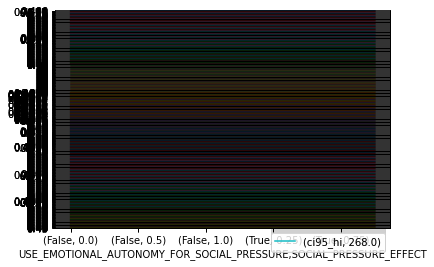

In [14]:
#code!

#import matplotlib.pyplot as plt
#plot_test = df.unstack(level=0).plot(kind='line', subplots=True)
#does not work?

In [74]:
myFig2 = go.Figure([
    go.Scatter(
        name='Mittelwert',
        #x=df['tick'],
        y=reset_df['mean'],
        mode='lines',
        line=dict(color='rgb(31, 119, 255)'),
    ),
    go.Scatter(
        name='Median',
        #x=df['tick'],
        y=reset_df['median'],
        mode='lines',
        line=dict(color='rgb(31, 255, 180)'),
    ),
    go.Scatter(
        name='Max',
        #x=df['tick'],
        y=reset_df['max'],
        mode='lines',
        marker=dict(color="#484"),
        line=dict(width=0),
        showlegend=True
    ),
    go.Scatter(
        name='Min',
        #x=df['tick'],
        y=reset_df['min'],
        marker=dict(color="#464"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 130, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ),
    go.Scatter(
        name='Konfidenzintervall',
        #x=df['tick'],
        y=reset_df['ci95_hi'],
        mode='lines',
        marker=dict(color="#644"),
        line=dict(width=0),
        showlegend=True
    ),
    go.Scatter(
        name='Konfidenzintervall',
        #x=df['tick'],
        y=reset_df['ci95_lo'],
        marker=dict(color="#448"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(130, 68, 68, 0.5)',
        fill='tonexty',
        showlegend=True
    )
])
myFig.update_layout(
    xaxis_title='X Achse',
    yaxis_title='Y Achse',
    title='Continuous, variable value error bars',
    hovermode="x"
)
myFig2.show()


In [18]:
import plotly.io as pio

subject = ['Moe','Larry','Curly','Moe','Larry','Curly','Moe','Larry','Curly','Moe','Larry','Curly']
score = [1,6,2,8,2,9,4,5,1,5,2,8]

data = [dict(
  type = 'scatter',
  x = subject,
  y = score,
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = subject,
    styles = [
        dict(target = 'Moe', value = dict(marker = dict(color = 'blue'))),
        dict(target = 'Larry', value = dict(marker = dict(color = 'red'))),
        dict(target = 'Curly', value = dict(marker = dict(color = 'black')))
    ]
  )]
)]

fig_dict = dict(data=data)
pio.show(fig_dict, validate=False)



In [111]:
#values = df.index.get_level_values(2)
values = df.index.unique()
values
#type(values)
#df["first_factor"]

MultiIndex([(  1.0,  0.0, False),
            (  1.0,  0.0,  True),
            (  1.0, 0.25, False),
            (  1.0, 0.25,  True),
            (  1.0,  0.5, False),
            (  1.0,  0.5,  True),
            (  1.0, 0.75, False),
            (  1.0, 0.75,  True),
            (  1.0,  1.0, False),
            (  1.0,  1.0,  True),
            ...
            (268.0,  0.0, False),
            (268.0,  0.0,  True),
            (268.0, 0.25, False),
            (268.0, 0.25,  True),
            (268.0,  0.5, False),
            (268.0,  0.5,  True),
            (268.0, 0.75, False),
            (268.0, 0.75,  True),
            (268.0,  1.0, False),
            (268.0,  1.0,  True)],
           names=['tick', 'first_factor', 'second_factor'], length=900)

In [194]:
#df.xs()

data_at_ignore_tick = df.loc[(slice(None), slice(None),["yes"]),:]
data_at_ignore_tick_reset = data_at_ignore_tick.reset_index()
data_at_ignore_tick_reset

,tick,first_factor,second_factor,mean,median,count,std,min,max,ci95_lo,ci95_hi
0,1.0,0.00,yes,0.489626,0.489175,30,0.004610,0.479253,0.499235,0.487905,0.491348
1,1.0,0.25,yes,0.490440,0.490955,30,0.003531,0.483509,0.497344,0.489122,0.491759
2,1.0,0.50,yes,0.489943,0.490419,30,0.003305,0.482307,0.495838,0.488709,0.491177
3,1.0,0.75,yes,0.490460,0.490510,30,0.002960,0.484881,0.497518,0.489355,0.491566
4,1.0,1.00,yes,0.489522,0.489153,30,0.002453,0.484613,0.493606,0.488605,0.490438
...,...,...,...,...,...,...,...,...,...,...,...
445,268.0,0.00,yes,0.471280,0.471226,30,0.001001,0.469043,0.473665,0.470906,0.471654
446,268.0,0.25,yes,0.471338,0.471530,30,0.001390,0.467830,0.474271,0.470819,0.471857
447,268.0,0.50,yes,0.469987,0.469942,30,0.000963,0.468108,0.471690,0.469627,0.470346
448,268.0,0.75,yes,0.467484,0.467925,30,0.001422,0.464921,0.470434,0.466953,0.468015


In [167]:
data_at_ignore_tick_reset.index.nlevels
#df.iloc(1)

1

In [181]:
#df = data_at_ignore_tick_reset
df


mean    median  count       std  \
tick  first_factor second_factor                                        
1.0   0.00         no             0.489803  0.489291     30  0.004103   
                   yes            0.489626  0.489175     30  0.004610   
      0.25         no             0.490416  0.490188     30  0.003058   
                   yes            0.490440  0.490955     30  0.003531   
      0.50         no             0.490133  0.490833     30  0.003642   
...                                    ...       ...    ...       ...   
268.0 0.50         yes            0.469987  0.469942     30  0.000963   
      0.75         no             0.459094  0.459207     30  0.001609   
                   yes            0.467484  0.467925     30  0.001422   
      1.00         no             0.449855  0.449570     30  0.001749   
                   yes            0.464206  0.464293     30  0.001207   

                                       min       max   ci95_lo   ci95_hi  
tick  first_factor second_factor                                          
1.0   0.00         no             0.480890  0.499673  0.488271  0.491335  
                   yes            0.479253  0.499235  0.487905  0.491348  
      0.25         no             0.483497  0.495958  0.489274  0.491557  
                   yes            0.483509  0.497344  0.489122  0.491759  
      0.50         no             0.483114  0.496181  0.488773  0.491493  
...                                    ...       ...       ...       ...  
268.0 0.50         yes            0.468108  0.471690  0.469627  0.470346  
      0.75         no             0.456083  0.461940  0.458494  0.459695  
                   yes            0.464921  0.470434  0.466953  0.468015  
      1.00         no             0.445721  0.452786  0.449202  0.450508  
                   yes            0.461878  0.466715  0.463756  0.464657  

[900 rows x 8 columns]

In [236]:
def add_trace_to_figure(plot_data, figure, col, row):
    figure.add_trace(
        go.Scatter(
            name='Mittelwert',
            y=plot_data['mean'],
            mode='lines',
            line=dict(color='rgb(31, 119, 255)'),
            ),
        row=row, col=col
        )
    figure.add_trace(
        go.Scatter(
            name='Median',
            y=plot_data['median'],
            mode='lines',
            line=dict(color='rgb(31, 255, 180)'),
            ),
        row=row, col=col
        )




In [214]:
number_of_plots = number_of_distinct_experiments
## Example with custom arrangement of plots
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=3, shared_yaxes="all")


In [ ]:
values_at_secondIndex = df.index.unique(1)
for first_level_value in values_at_secondIndex:
    values_at_third_index = df.index.unique(2)
    #print("values at third level "+values_at_third_index)
    for second_level_value in values_at_third_index:
        if df.index.nlevels > 3:
            values_at_fourth_index = df.index.unique(3)
            for third_level_value in values_at_fourth_index:
                 print(str(first_level_value) + " -> "+str(second_level_value) + " -> "+str(third_level_value))
        else:
            #print("all = "+values_at_third_index)
            #print("first = " + str(first_level_value) + " -> second = "+str(second_level_value))
            data_ignore_tick = df.loc[(slice(None), [first_level_value],[second_level_value]),:]
            #print("subset")
            #print(data_ignore_tick)
            add_trace_to_figure(data_ignore_tick, fig, 1, 1)



fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

In [ ]:
fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()


In [258]:
number_of_plots = number_of_distinct_experiments
## Example with custom arrangement of plots
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2)

# add_trace_to_figure(df, fig,2,2)
fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()


In [259]:
#0
data_select = df.loc[(slice(None), [0.0],["yes"]),:]
add_trace_to_figure(data_select, fig,1,1)
data_select

,,,mean,median,count,std,min,max,ci95_lo,ci95_hi
tick,first_factor,second_factor,,,,,,,,
1.0,0.0,yes,0.489626,0.489175,30,0.004610,0.479253,0.499235,0.487905,0.491348
4.0,0.0,yes,0.488422,0.488039,30,0.004492,0.479761,0.497502,0.486744,0.490099
7.0,0.0,yes,0.510987,0.511145,30,0.003867,0.504557,0.519822,0.509543,0.512432
10.0,0.0,yes,0.523522,0.523893,30,0.002868,0.518088,0.528580,0.522451,0.524593
13.0,0.0,yes,0.529717,0.529973,30,0.002538,0.525396,0.535401,0.528769,0.530664
...,...,...,...,...,...,...,...,...,...,...
256.0,0.0,yes,0.471876,0.471825,30,0.000958,0.470512,0.473963,0.471518,0.472234
259.0,0.0,yes,0.472070,0.472194,30,0.001089,0.469792,0.474279,0.471663,0.472476
262.0,0.0,yes,0.471691,0.471756,30,0.000837,0.470215,0.473407,0.471378,0.472003


In [ ]:
data_select = df.loc[(slice(None), [0.0],["no"]),:]
add_trace_to_figure(data_select, fig,1,1)


#0.25
data_select = df.loc[(slice(None), [0.25],["yes"]),:]
add_trace_to_figure(data_select, fig,1,2)

data_select = df.loc[(slice(None), [0.25],["no"]),:]
add_trace_to_figure(data_select, fig,1,2)



#0.5
data_select = df.loc[(slice(None), [0.5],["yes"]),:]
add_trace_to_figure(data_select, fig,1,3)

data_select = df.loc[(slice(None), [0.5],["no"]),:]
add_trace_to_figure(data_select, fig,1,3)



#0.75
data_select = df.loc[(slice(None), [0.75],["yes"]),:]
add_trace_to_figure(data_select, fig,2,1)

data_select = df.loc[(slice(None), [0.75],["no"]),:]
add_trace_to_figure(data_select, fig,2,1)


#0.1
data_select = df.loc[(slice(None), [1.0],["yes"]),:]
add_trace_to_figure(data_select, fig,2,2)

data_select = df.loc[(slice(None), [1.0],["no"]),:]
add_trace_to_figure(data_select, fig,2,2)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()



In [249]:
# next try from stackoverflow: https://stackoverflow.com/questions/61494278/plotly-how-to-make-a-figure-with-multiple-lines-and-shaded-area-for-standard-de/61501980#61501980
# df = reset_df

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
# sample data in a pandas dataframe

np.random.seed(1)
df_for_plot =pd.DataFrame(dict(A=np.random.uniform(low=-1, high=2, size=25).tolist(),
                    B=np.random.uniform(low=-4, high=3, size=25).tolist(),
                    C=np.random.uniform(low=-1, high=3, size=25).tolist(),
                    ))
df_for_plot = df_for_plot.cumsum()

In [301]:
df_for_plot

,A,B,C
0,0.251066,2.262247,-0.922532
1,1.412039,-1.142444,0.792810
2,0.412383,-4.869060,0.639322
3,0.319380,-7.680247,0.701509
4,-0.240352,-5.533250,1.667802
5,-0.963336,-8.844822,0.881252
6,-1.404556,-9.897069,2.177722
7,-1.367873,-7.191842,1.764637
8,-1.177571,-7.459685,3.121859
9,-0.561121,-6.616545,4.920892


In [333]:

# define colors as a list
colors = px.colors.qualitative.Plotly

# convert plotly hex colors to rgba to enable transparency adjustments
def hex_rgba(hex, transparency):
    col_hex = hex.lstrip('#')
    col_rgb = list(int(col_hex[i:i+2], 16) for i in (0, 2, 4))
    col_rgb.extend([transparency])
    areacol = tuple(col_rgb)
    return areacol

rgba = [hex_rgba(c, transparency=0.4) for c in colors]
colCycle = ['rgba'+str(elem) for elem in rgba]

# Make sure the colors run in cycles if there are more lines than colors
def next_col(cols):
    while True:
        for col in cols:
            yield col
line_color=next_col(cols=colCycle)

In [302]:
one_experiment = reset_df.loc[(reset_df["first_factor"] == 0.5) & reset_df["second_factor"] == True]
df_for_plot = one_experiment

In [305]:
# plotly  figure



ValueError: too many values to unpack (expected 2)

In [311]:
data_for_plot =  reset_df.loc[(reset_df["first_factor"] == 0.5)]
values_of_second_factor = data_for_plot["second_factor"].drop_duplicates()
type(values_of_second_factor)

pandas.core.series.Series

In [334]:
# add line and shaded area for each series and standards deviation
#for i, experiment in values_of_second_factor:#
fig = go.Figure()
for index, value in values_of_second_factor.items():
    print("current experiment for "+ str(value))
    df_for_plot = data_for_plot[(data_for_plot["second_factor"] == value)]
    #print(df_for_plot)

    #runs over all columns -> instead of columns i need the values of the second factor
    new_col = next(line_color)
    x =  df_for_plot["tick"]
    y1 = df_for_plot["mean"]
    y1_upper =  df_for_plot["ci95_hi"]
    y1_lower =  df_for_plot["ci95_lo"]

    # standard deviation area
    fig.add_traces(go.Scatter(x=x,
                                y=y1_upper,
                                fill='tozerox',
                                fillcolor=new_col,
                                line=dict(color='rgba(255,255,255,0)'),
                                showlegend=True,
                                name="ci "+str(value)))

    # line trace
    fig.add_traces(go.Scatter(x=x,
                              y=y1,
                              line=dict(color=new_col, width=2.5),
                              mode='lines',
                              name="mean "+str(value))
                                )
# set x-axis
fig.update_layout(xaxis=dict(range=[1,len(df_for_plot)]))

fig.show()



current experiment for False
current experiment for True
